# Dissertation - compact city for London

## 0. Setting up the environment

In [1]:
%reset -f

In [2]:
#pip install networkx-metis

In [3]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely
import rasterio
import fiona
import networkx as nx
import gemgis as gg
import momepy
from libpysal import weights
from shapely.geometry import Polygon
import numpy as np

In [23]:
'''
# For google colab
from google.colab import drive
drive.mount('/content/drive')
'''

"\n# For google colab\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

## 1. Loading and cleaning the data

### 1.1 London boundary

In [4]:
boundary_wards = gpd.read_file(os.path.join('data', 'raw', 'London-wards-2018', 'London_Ward_CityMerged.shp'))

<AxesSubplot:>

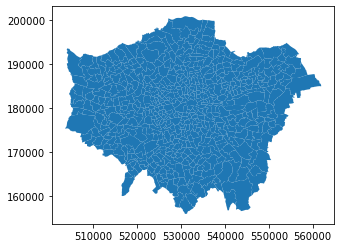

In [5]:
boundary_wards.plot()

In [6]:
type(boundary_wards)

geopandas.geodataframe.GeoDataFrame

In [7]:
# Get the outer boundary
boundary_london = gpd.GeoDataFrame(gpd.GeoSeries(data=boundary_wards.unary_union, crs='epsg:27700')).rename(columns={0:'original'})
boundary_london['geometry'] = boundary_london 
boundary_london = boundary_london.set_geometry('geometry')
boundary_london = boundary_london.set_crs('epsg:27700')

boundary_london_buffer = boundary_london.buffer(800) # 800 m buffer to mitigate the edge effect
boundary_london_buffer.plot()

GEOSException: IllegalArgumentException: Argument must be Polygonal or LinearRing

### 1.2 Road network data (OS open road)

#### 1.2.1 Cleaning the road network data

Dimension in British National Grid, London: TQ (main fille) and TL (top but of London)

In [34]:
# Read in the road network shapefiles
folder = os.path.join('data', 'raw', 'road_network')
#folder = os.path.join('/content/drive/My Drive/Colab_Notebooks/', 'data', 'raw', 'oproad_essh_gb', 'data')

In [35]:
# Extracting shapefile names for each type
from os import listdir
from os.path import isfile, join

link_shapes = [f for f in listdir(folder) if join(folder, f).endswith('RoadLink.shp')]
#node_shapes = [f for f in listdir(folder) if join(folder, f).endswith('RoadNode.shp')]
#motorway_jct_shapes = [f for f in listdir(folder) if join(folder, f).endswith('MotorwayJunction.shp')]

In [36]:
len(link_shapes) #2 - TQ, TL

2

In [37]:
# Join all link files (https://stackoverflow.com/questions/48874113/concat-multiple-shapefiles-via-geopandas)
road_links = pd.concat([gpd.read_file(os.path.join(folder,file)) for file in link_shapes]).pipe(gpd.GeoDataFrame)

<AxesSubplot:>

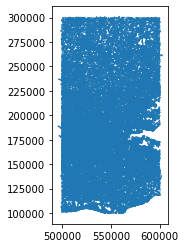

In [38]:
road_links.plot()

In [39]:
road_links.head(5)

,fictitious,identifier,class,roadNumber,name1,name1_lang,name2,name2_lang,formOfWay,length,primary,trunkRoad,loop,startNode,endNode,structure,nameTOID,numberTOID,function,geometry
0,false,894A4A1F-5226-4861-8D77-B6A01F160C2A,Unclassified,None,Fen Street,None,None,None,Single Carriageway,973,false,false,false,1EA70202-D81F-40DE-9490-06259D09AB55,BCCE62EA-9209-491F-AE41-C4B776A6D1D7,None,osgb4000000028032555,None,Minor Road,"LINESTRING Z (598752.530 295978.250 0.000, 598..."
1,false,AADD330B-9C87-4E9B-85C1-A6224AE7D001,Unclassified,None,Sandy Lane,None,None,None,Single Carriageway,22,false,false,false,A568AC7B-0A23-4C37-AD55-7AAE24C5ADE3,1FA4C5FE-862B-4565-BED1-42A80A645B21,None,osgb4000000028040845,None,Minor Road,"LINESTRING Z (598768.690 295005.270 0.000, 598..."
2,false,8F0E7A2C-20BE-45BC-8C72-E7DB1403DAA1,Unclassified,None,Fen Street,None,None,None,Single Carriageway,18,false,false,false,BCCE62EA-9209-491F-AE41-C4B776A6D1D7,1FA4C5FE-862B-4565-BED1-42A80A645B21,None,osgb4000000028032555,None,Minor Road,"LINESTRING Z (598757.270 295017.470 0.000, 598..."
3,false,CC43DB6F-CFAC-49C0-AFFC-B38B9DA79C11,Unclassified,None,None,None,None,None,Single Carriageway,168,false,false,false,EA1A8FC5-4AD0-4A56-8D96-19D269EF8974,1EA70202-D81F-40DE-9490-06259D09AB55,None,None,None,Minor Road,"LINESTRING Z (598919.150 295969.850 0.000, 598..."
4,false,C39B830D-0362-4B29-B2BC-8D5563615170,Unclassified,None,Rectory Road,None,None,None,Single Carriageway,191,false,false,false,472B7AA5-F9EF-4998-A917-CA89299AB4B7,1EA70202-D81F-40DE-9490-06259D09AB55,None,osgb4000000028035379,None,Minor Road,"LINESTRING Z (598798.690 296160.680 0.000, 598..."


In [40]:
road_links.columns

Index(['fictitious', 'identifier', 'class', 'roadNumber', 'name1',
       'name1_lang', 'name2', 'name2_lang', 'formOfWay', 'length', 'primary',
       'trunkRoad', 'loop', 'startNode', 'endNode', 'structure', 'nameTOID',
       'numberTOID', 'function', 'geometry'],
      dtype='object')

In [41]:
road_links = road_links.set_crs('epsg:27700')

In [42]:
# Drop non-needed columns
columns = ['fictitious', 'class', 'roadNumber', 'name1', 'name1_lang', 'name2', 'name2_lang', 'primary',
       'trunkRoad', 'loop', 'structure', 'nameTOID', 'numberTOID']
road_links.drop(axis=0, columns=columns, inplace=True)

In [43]:
# Save file
road_links.to_file(os.path.join('data', 'clean', 'combined_roadlinks.shp'))

#### 1.2.2 Extracting the road data within London - links

In [ ]:
# Extract those in London
road_links_london = gpd.clip(road_links, boundary_london_buffer)

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
road_links_london.plot(ax=ax)
fig.savefig(os.path.join("figure","road_links_london"))

In [ ]:
road_links_london.head(2)

In [ ]:
# Save file (https://geopandas.org/en/stable/docs/user_guide/set_operations.html)
road_links_london.to_file(os.path.join('data', 'clean', 'london_roadlinks.shp'))

#### 1.2.3 Creating a network

In [ ]:
# Explode gdf to avoid multipart geometry (https://gis.stackexchange.com/questions/378806/multi-part-geometries-do-not-provide-a-coordinate-sequence-error-when-extracti)
road_links_london.reset_index(drop=True, inplace = True)
road_links_london = road_links_london.explode()

In [ ]:
# geopanas to network (https://networkx.org/documentation/stable/auto_examples/geospatial/plot_lines.html)
G = momepy.gdf_to_nx(road_links_london, approach="primal")


In [ ]:
positions = {n: [n[0], n[1]] for n in list(G.nodes)}

In [ ]:
# Plot
fig, ax = plt.subplots(1, 2, figsize=(500, 300), sharex=True, sharey=True)
road_links_KC.plot(color="k", ax=ax[0])
for i, facet in enumeraG.nodes(data = True)te(ax):
    facet.set_title(("Roads", "Graph")[i])
    facet.axis("off")
nx.draw(G, positions, ax=ax[1], node_size=5)

fig.savefig(os.path.join("figure","road_graph_london"))

### 1.3 POI data (OS)

#### 1.3.1 Transport data

In [55]:
# 57 Public transport, stations and infrastructure, 59 Bus transport
poi_transport = pd.read_csv(os.path.join('data', 'raw', 'poi_transport', 'poi-extract-2022_03.csv'))

In [56]:
poi_transport.columns

Index(['ref_no', 'name', 'pointx_class', 'feature_easting', 'feature_northing',
       'pos_accuracy', 'uprn', 'topo_toid', 'topo_toid_version', 'usrn',
       'usrn_mi', 'distance', 'address_detail', 'street_name', 'locality',
       'geographic_county', 'postcode', 'admin_boundary', 'telephone_number',
       'url', 'brand', 'qualifier_type', 'qualifier_data', 'provenance',
       'supply_date'],
      dtype='object')

In [57]:
# Drop non-needed columns
columns = ['ref_no', 'name', 'pos_accuracy', 'uprn', 'topo_toid', 'topo_toid_version', 'usrn',
       'usrn_mi', 'distance', 'address_detail', 'street_name', 'locality',
       'geographic_county', 'postcode', 'admin_boundary', 'telephone_number',
       'url', 'brand', 'qualifier_type', 'qualifier_data', 'provenance',
       'supply_date']
poi_transport.drop(axis=0, columns=columns, inplace=True)

In [58]:
# Converting to geopandas
poi_transport = gpd.GeoDataFrame(
    poi_transport, geometry=gpd.points_from_xy(poi_transport['feature_easting'], poi_transport['feature_northing']))

In [59]:
poi_transport.drop(axis=0, columns=['feature_easting', 'feature_northing'], inplace=True)

In [60]:
poi_transport = poi_transport.set_crs('epsg:27700')

In [61]:
# Extract those in London
poi_transport_london = gpd.clip(poi_transport, boundary_london_buffer)

NameError: name 'boundary_london_buffer' is not defined

NameError: name 'poi_transport_london' is not defined

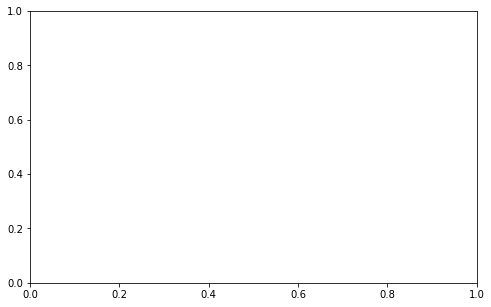

In [62]:
fig, ax = plt.subplots(figsize=(8,5))
poi_transport_london.plot(markersize=3, ax=ax)
fig.savefig(os.path.join("figure","poi_transport_london"))

In [ ]:
poi_transport_london['pointx_class'] = poi_transport_london['pointx_class'].astype(int)

In [ ]:
poi_transport_london

In [ ]:
# Save file 
poi_transport_london.to_file(os.path.join('data', 'clean', 'london_poi_transport.shp'))

### 2. Explore data

In [ ]:
poi_transport.groupby(['pointx_class']).count()

### For experiment - with Kings Cross only

<AxesSubplot:>

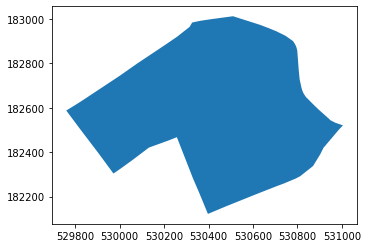

In [29]:
boundary_KC = boundary_wards[boundary_wards['NAME']=="King's Cross"]
boundary_KC.plot()

<AxesSubplot:>

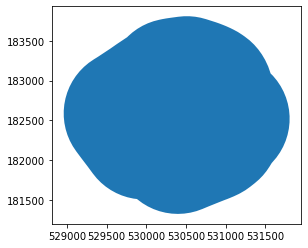

In [30]:
boundary_KC_buffer = boundary_KC.buffer(800) # 800 m
boundary_KC_buffer.plot()

In [44]:
# Extract road links in King's Cross
road_links_KC = gpd.clip(road_links, boundary_KC_buffer)

<AxesSubplot:>

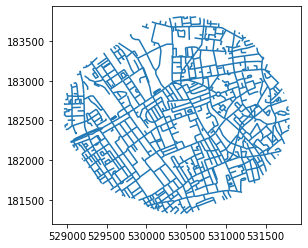

In [45]:
road_links_KC.plot()

In [46]:
# Explode gdf to avoid multipart geometry (https://gis.stackexchange.com/questions/378806/multi-part-geometries-do-not-provide-a-coordinate-sequence-error-when-extracti)
road_links_KC.reset_index(drop=True, inplace = True)
road_links_KC = road_links_KC.explode()


In [47]:
road_links_KC.head()

,,identifier,formOfWay,length,startNode,endNode,function,geometry
0,0,5DA15C7A-CB10-4AF2-B081-3311D93F3E9A,Single Carriageway,143,56980A93-BF25-4C5D-AE80-1DD2DF56C59B,097DC8E4-D524-4433-8D03-2D666258A255,B Road,"LINESTRING Z (530502.617 181329.658 0.000, 530..."
1,0,061FB621-E4C9-4716-8FD1-DADE5168946D,Single Carriageway,179,E94A38AF-5AF2-4478-81C8-29E087B8C799,A1014BCD-A4AA-420C-82F9-743181632A37,Local Road,"LINESTRING Z (530477.370 181370.970 0.000, 530..."
2,0,EE87C7F9-67E8-42B8-8409-9B0DF42E173B,Collapsed Dual Carriageway,95,56A98C0D-5A41-4D3A-8C35-AA7F0A217D76,4CA1EFDB-1B47-41CA-A8B0-1649666D7727,A Road,"LINESTRING Z (530568.650 181393.260 0.000, 530..."
3,0,CEA89503-9A64-48E9-855B-CCBBECC194E6,Single Carriageway,47,E94A38AF-5AF2-4478-81C8-29E087B8C799,097DC8E4-D524-4433-8D03-2D666258A255,Local Road,"LINESTRING Z (530477.370 181370.970 0.000, 530..."
4,0,423AEAA1-CC8B-4B70-9709-A697F0E764FB,Single Carriageway,85,097DC8E4-D524-4433-8D03-2D666258A255,56A98C0D-5A41-4D3A-8C35-AA7F0A217D76,B Road,"LINESTRING Z (530507.000 181335.000 0.000, 530..."


In [48]:
# Save file 
road_links_KC.to_file(os.path.join('data', 'clean_KC', 'KC_roadlinks.shp'))

In [49]:
# geopanas to network (https://networkx.org/documentation/stable/auto_examples/geospatial/plot_lines.html)
G_KC = momepy.gdf_to_nx(road_links_KC, approach="primal")

In [50]:
positions_KC = {n: [n[0], n[1]] for n in list(G_KC.nodes)}

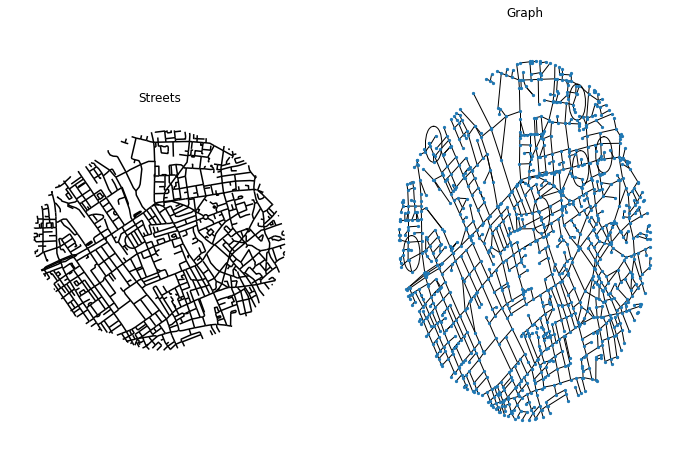

In [51]:
# Plot
fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharex=True, sharey=True)
road_links_KC.plot(color="k", ax=ax[0])
for i, facet in enumerate(ax):
    facet.set_title(("Streets", "Graph")[i])
    facet.axis("off")
nx.draw(G_KC, positions_KC, ax=ax[1], node_size=5)

fig.savefig(os.path.join("figure","road_graph_london"))

In [52]:
# Extract transport POS in London
poi_transport_KC = gpd.clip(poi_transport, boundary_KC_buffer)

NameError: name 'poi_transport' is not defined

In [53]:
poi_transport_KC.groupby(['pointx_class']).count()

NameError: name 'poi_transport_KC' is not defined

In [54]:
# Save file 
poi_transport_KC.to_file(os.path.join('data', 'clean_KC', 'KC_poi_transport.shp'))

NameError: name 'poi_transport_KC' is not defined

In [ ]:
# Plot on the road network
fig, ax = plt.subplots(figsize=(8,5))
poi_transport_KC.plot(markersize=3, ax=ax, color = 'r')
nx.draw(G_KC, positions_KC, ax=ax, node_size=5)

fig.savefig(os.path.join("figure","road_graph_POI_KC"))

## 2. Routing calculation

"1.5-km distance was used and is consistent with common definitions used in walkability studies which equate a 5-minute walk to 400 m - Thornton et al"

In [ ]:
# Re-loading the data
road_links_london = gpd.read_file(os.path.join('data', 'clean', 'london_roadlinks.shp'))
poi_transport_london = gpd.read_file(os.path.join('data', 'clean', 'london_poi_transport.shp'))

In [ ]:
# Reconstructing the network
road_links_london.reset_index(drop=True, inplace = True)
road_links_london = road_links_london.explode()

G = momepy.gdf_to_nx(road_links_london, approach="primal")
positions = {n: [n[0], n[1]] for n in list(G.nodes)}

### For experiment - with Kings Cross only

In [13]:
# Re-loading the data
road_links_KC = gpd.read_file(os.path.join('data', 'clean_KC', 'KC_roadlinks.shp'))
poi_transport_KC = gpd.read_file(os.path.join('data', 'clean_KC', 'KC_poi_transport.shp'))

In [14]:
# Reconstructing the network
road_links_KC.reset_index(drop=True, inplace = True)
road_links_KC = road_links_KC.explode()

G_KC = momepy.gdf_to_nx(road_links_KC, approach="primal")
positions_KC = {n: [n[0], n[1]] for n in list(G_KC.nodes)}

In [15]:
# Read grids
grid_KC = gpd.read_file(os.path.join('data', 'clean_KC', 'KC_grid.shp'))

#### a. Find the closest node from each POI

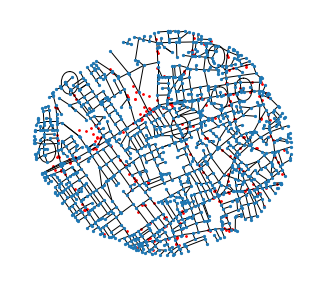

In [16]:
# Plot on the road network
fig, ax = plt.subplots(figsize=(8,5))
poi_transport_KC.plot(markersize=3, ax=ax, color = 'r')
nx.draw(G_KC, positions_KC, ax=ax, node_size=5)

fig.savefig(os.path.join("figure","road_graph_POI_KC"))

In [17]:
G_KC.nodes

NodeView(((530339.99, 183676.11000000002, 0.0), (530315.96, 183677.37, 0.0), (529946.4420007855, 183687.1773029053, 0.0), (529993.86, 183669.91, 0.0), (530235.6900000001, 183696.71, 0.0), (530368.0, 183677.0, 0.0), (530364.0700000001, 183730.0, 0.0), (530170.34, 183711.68, 0.0), (530008.8323623323, 183717.19729000988, 0.0), (530118.27, 183723.79, 0.0), (530247.61, 183746.46, 0.0), (530180.46, 183755.35, 0.0), (530068.1664538211, 183739.79110395932, 0.0), (530291.4950392181, 183789.22373923135, 0.0), (530553.0, 183794.0, 0.0), (530560.63, 183728.31, 0.0), (530911.2164457875, 183722.2700774051, 0.0), (530909.02, 183669.89, 0.0), (530469.48, 183797.28, 0.0), (530443.04, 183793.83000000002, 0.0), (530442.0, 183803.0, 0.0), (530809.9502852095, 183755.67440749364, 0.0), (530809.0, 183716.0, 0.0), (530514.4455746876, 183810.82734669177, 0.0), (530626.8068661827, 183802.58044797395, 0.0), (530334.70570165, 183795.22992294462, 0.0), (530468.5225947516, 183810.31134921432, 0.0), (530441.48820793

In [18]:
poi_transport_KC

,pointx_cla,geometry
0,10590732,POINT (531311.000 183430.000)
1,10590732,POINT (531108.000 183516.000)
2,10590732,POINT (531092.000 183536.000)
3,10590732,POINT (530714.000 183552.000)
4,10590732,POINT (530333.000 183567.000)
...,...,...
221,10590732,POINT (530016.000 182228.000)
222,10570794,POINT (529256.000 182260.000)
223,10570794,POINT (529263.000 182267.000)
224,10590732,POINT (529190.000 182270.000)


#### b. Construct a grid -> find the closest node for each centroid

In [19]:
'''
xmin, ymin, xmax, ymax = boundary_KC_buffer.total_bounds

length = 50
wide = 50

cols = list(np.arange(xmin, xmax + wide, wide))
rows = list(np.arange(ymin, ymax + length, length))

polygons = []
for x in cols[:-1]:
    for y in rows[:-1]:
        polygons.append(Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)]))

grid_KC = gpd.GeoDataFrame({'geometry':polygons})
grid_KC.to_file(os.path.join('data', 'clean_KC', 'KC_grid.shp'))
'''

"\nxmin, ymin, xmax, ymax = boundary_KC_buffer.total_bounds\n\nlength = 50\nwide = 50\n\ncols = list(np.arange(xmin, xmax + wide, wide))\nrows = list(np.arange(ymin, ymax + length, length))\n\npolygons = []\nfor x in cols[:-1]:\n    for y in rows[:-1]:\n        polygons.append(Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)]))\n\ngrid_KC = gpd.GeoDataFrame({'geometry':polygons})\ngrid_KC.to_file(os.path.join('data', 'clean_KC', 'KC_grid.shp'))\n"

In [20]:
grid_KC['centroid'] = grid_KC.centroid

In [21]:
grid_KC

,FID,geometry,centroid
0,0,"POLYGON ((528960.255 181321.799, 528960.255 18...",POINT (528985.255 181346.799)
1,1,"POLYGON ((528960.255 181371.799, 528960.255 18...",POINT (528985.255 181396.799)
2,2,"POLYGON ((528960.255 181421.799, 528960.255 18...",POINT (528985.255 181446.799)
3,3,"POLYGON ((528960.255 181471.799, 528960.255 18...",POINT (528985.255 181496.799)
4,4,"POLYGON ((528960.255 181521.799, 528960.255 18...",POINT (528985.255 181546.799)
...,...,...,...
2845,2845,"POLYGON ((531760.255 183571.799, 531760.255 18...",POINT (531785.255 183596.799)
2846,2846,"POLYGON ((531760.255 183621.799, 531760.255 18...",POINT (531785.255 183646.799)
2847,2847,"POLYGON ((531760.255 183671.799, 531760.255 18...",POINT (531785.255 183696.799)
2848,2848,"POLYGON ((531760.255 183721.799, 531760.255 18...",POINT (531785.255 183746.799)


## 3. Computing the composite measure

## 4. Evaluating the compositite measure